In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
## hper parameter
num_epochs = 3
batch_size = 4
learning_rate = 0.001

In [4]:
## dataset has PILImage images of range [0, 1]. 
## We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
## CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
training_dataset = torchvision.datasets.CIFAR10(root='./cifar_folder', 
                                           train=True, 
                                           transform= transform, 
                                           download=True)

testing_dataset = torchvision.datasets.CIFAR10(root='./cifar_folder', 
                                          train=False,
                                          transform= transform, 
                                          download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(dataset= training_dataset,
                                           batch_size= batch_size,
                                           shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset= testing_dataset,
                                           batch_size= batch_size,
                                           shuffle= False)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
dataiter = iter(train_loader)
image, label = next(dataiter)

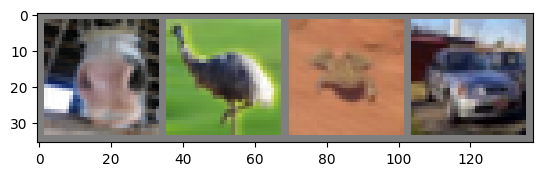

In [9]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(image))

In [10]:
image.shape         ## 4 => batch size .... 3 => color channel  ....  32*32 => pixel size

torch.Size([4, 3, 32, 32])

In [11]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 6, kernel_size= 5)
        self.pool1 = nn.MaxPool2d(kernel_size= 2, stride= 2)                        ## (W − K + 2P) / S  =>     w =: input size in this case 32
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels= 16, kernel_size= 5)                            ##  k =: K is the Kernel size
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                                                               ##  p =: padding (0)  s =: stride (0)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # def forward(self, x):
    #     # -> n, 3, 32, 32
    #     x = self.pool1(F.relu(self.conv1(x)))           ## -> n, 6, 14, 14
    #     x = self.pool1(F.relu(self.conv2(x)))           ## -> n, 16, 5, 5
    #     x = x.view(-1, 16 * 5 * 5)                      ## -> n, 400
    #     x = F.relu(self.fc1(x))                         ## -> n, 120
    #     x = F.relu(self.fc2(x))                         ## -> n, 84
    #     x = self.fc3(x)                                 ## -> n, 10
    #     return x

    def forward(self, x):
        # -> n, 3, 32, 32

        x_conv1 = self.conv1(x)
        x_relu1 = torch.relu(x_conv1)
        x_pool1 = self.pool1(x_relu1)

        x_conv2 = self.conv2(x_pool1)
        x_relu2 = torch.relu(x_conv2)
        x_pool2 = self.pool1(x_relu2)

        x_flatten = x_pool2.view(-1, 16 * 5 * 5)

        x_fully_connected_1 = self.fc1(x_flatten)
        x_relu3 = torch.relu(x_fully_connected_1)

        x_fully_connected_2 = self.fc2(x_relu3)
        x_relu4 = torch.relu(x_fully_connected_2)

        x_fully_connected_3 = self.fc3(x_relu4)
        
        return x_fully_connected_3

In [12]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/3], Step [2000/12500], Loss: 2.3285
Epoch [1/3], Step [4000/12500], Loss: 2.3090
Epoch [1/3], Step [6000/12500], Loss: 2.2854
Epoch [1/3], Step [8000/12500], Loss: 2.3126
Epoch [1/3], Step [10000/12500], Loss: 2.1552
Epoch [1/3], Step [12000/12500], Loss: 2.3150
Epoch [2/3], Step [2000/12500], Loss: 2.0423
Epoch [2/3], Step [4000/12500], Loss: 1.8411
Epoch [2/3], Step [6000/12500], Loss: 1.8718
Epoch [2/3], Step [8000/12500], Loss: 2.6604
Epoch [2/3], Step [10000/12500], Loss: 1.8431
Epoch [2/3], Step [12000/12500], Loss: 1.6320
Epoch [3/3], Step [2000/12500], Loss: 1.7615
Epoch [3/3], Step [4000/12500], Loss: 1.8745
Epoch [3/3], Step [6000/12500], Loss: 1.5050
Epoch [3/3], Step [8000/12500], Loss: 1.7377
Epoch [3/3], Step [10000/12500], Loss: 1.2346
Epoch [3/3], Step [12000/12500], Loss: 1.2409


In [14]:

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Finished Training
Accuracy of the network: 40.27 %
Accuracy of plane: 49.8 %
Accuracy of car: 49.2 %
Accuracy of bird: 7.9 %
Accuracy of cat: 11.2 %
Accuracy of deer: 49.4 %
Accuracy of dog: 49.7 %
Accuracy of frog: 52.2 %
Accuracy of horse: 46.6 %
Accuracy of ship: 40.3 %
Accuracy of truck: 46.4 %
